In [1]:
import mujoco,cv2,pyvista
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from utils.mujoco_parser import MuJoCoParserClass

from utils.util import sample_xyzs,rpy2r,r2rpy,r2quat,compute_view_params,get_interp_const_vel_traj, printmd
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[3.1.4]


In [2]:
xml_path = '../../asset/visualize_figure_dish_rack_small.xml'
env = MuJoCoParserClass(name='Place task scene: Plate table',rel_xml_path=xml_path,VERBOSE=False, MODE='window')
print(env.MODE)

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('base').pos = np.array([0.18,0,0.79])
env.model.body('avoiding_object_table').pos = np.array([0.38+0.45,0,0])
env.model.body('right_object_table').pos = np.array([-0.05,-0.80,0])
env.model.body('left_object_table').pos = np.array([-1.5,80,0])

# Place objects
obj_box_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_box"))]
n_box_obj = len(obj_box_names)
env.place_objects_random(n_obj=n_box_obj, obj_names=obj_box_names, x_range=[0.80, 1.15], y_range=[-3.15, -2.15], COLORS=False, VERBOSE=True)

jntadr_mug_cup = env.model.body('mug_cup').jntadr[0]
env.model.joint(jntadr_mug_cup).qpos0[:3] = np.array([ -0.9, -30, 0.85])
env.model.joint(jntadr_mug_cup).qpos0[3:] = r2quat(rpy2r(np.radians([0, 0, np.random.rand() * 360])))

jntadr_tray = env.model.body('tray').jntadr[0]
env.model.joint(jntadr_tray).qpos0[:3] = np.array([-0.9,-30,0.80])
# env.model.joint(jntadr_tray).qpos0[3:] = r2quat(rpy2r(np.radians([0, 0, 0])))

jntadr_dish_rack = env.model.body('rack_base').jntadr[0]
pos_dish_rack = np.array([0.9,0.0,0.82])
env.model.joint(jntadr_dish_rack).qpos0[:3] = pos_dish_rack
dish_rack_random_rot = 0 # np.random.rand() * 360
env.model.joint(jntadr_dish_rack).qpos0[3:] = r2quat(rpy2r(np.radians([0, 0, dish_rack_random_rot])))


# Target dish
env.model.joint(env.model.body('kitchen-plate').jntadr[0]).qpos0[:3] = np.array([0.2, -0.7, 0.8])
# Set the dishes
env.model.joint(env.model.body('kitchen-plate-2').jntadr[0]).qpos0[:3] = pos_dish_rack + np.array([0.,0.0, 0.15])
env.model.joint(env.model.body('kitchen-plate-2').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([0, 90, 90])))
env.model.joint(env.model.body('kitchen-plate-3').jntadr[0]).qpos0[:3] = pos_dish_rack + np.array([0., -0.1, 0.15])
env.model.joint(env.model.body('kitchen-plate-3').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([0, 90, 90])))
env.model.joint(env.model.body('kitchen-plate-4').jntadr[0]).qpos0[:3] = pos_dish_rack + np.array([-2.5, 0.1, 0.15])
env.model.joint(env.model.body('kitchen-plate-4').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([0, 90, 90])))

env.reset()

window


[ 0.5  -0.01  1.16]


2025-06-14 13:06:48.707 python[36831:1748608] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


Pressed ESC
Quitting.


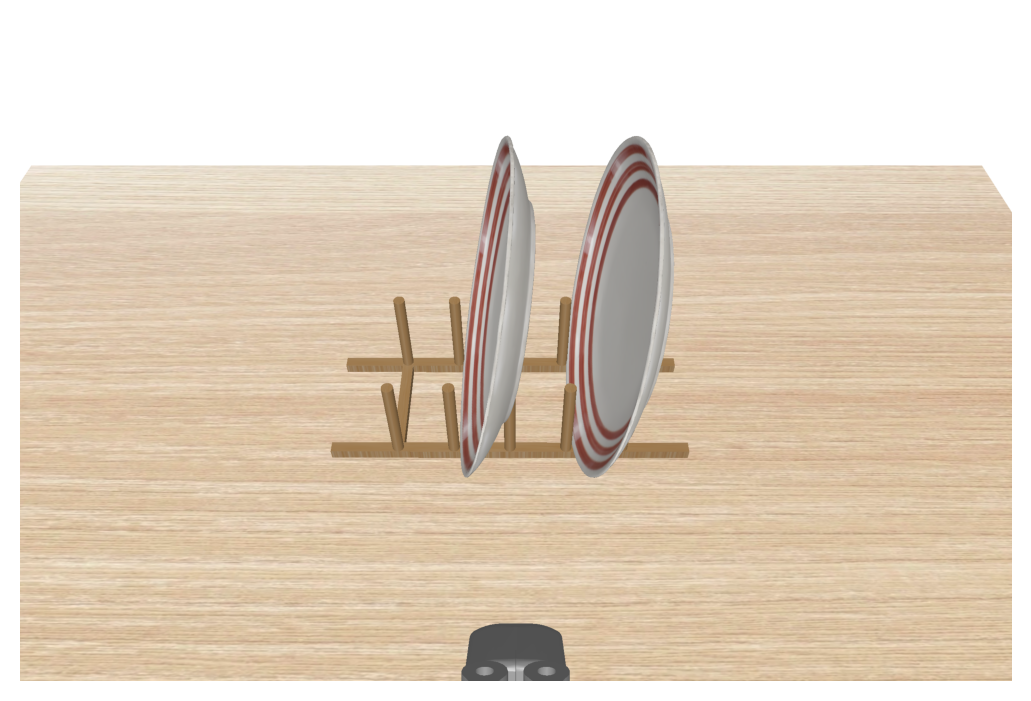

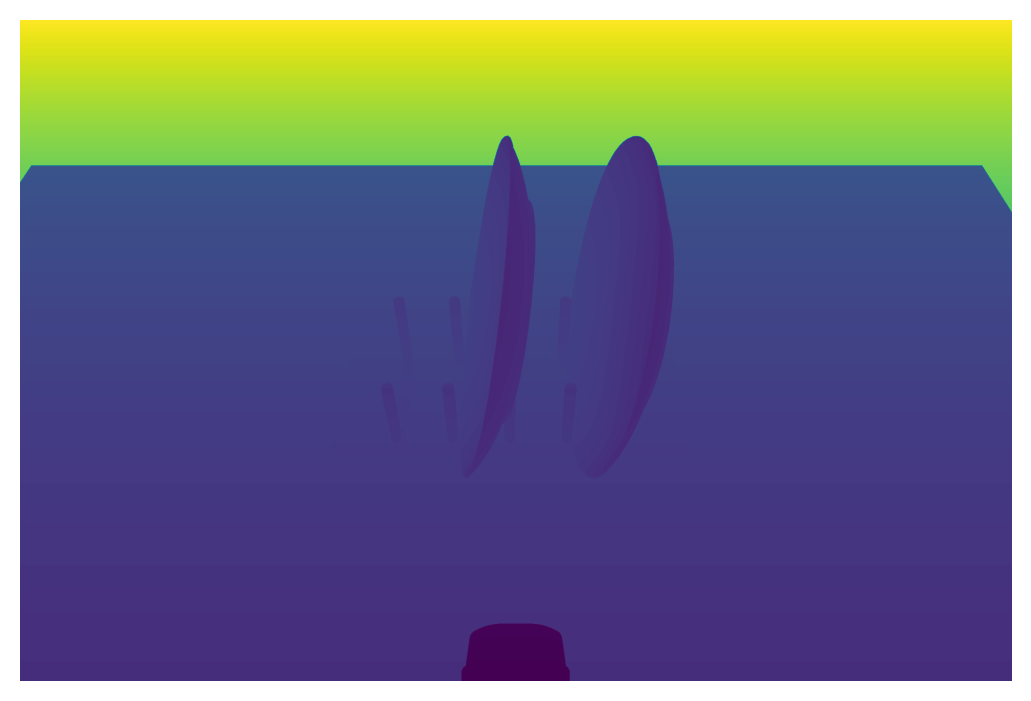

Done. Tick:[752] Time:[1.50]sec


In [3]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=150,distance=3.0,elevation=-30,lookat=[0.4,0.0,0.81],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

pcd_tick = 0

# Reset
env.reset()
init_ur_q = np.array([np.deg2rad(-90), np.deg2rad(-130), np.deg2rad(120), np.deg2rad(100), np.deg2rad(45), np.deg2rad(-90)])
env.forward(q=init_ur_q, joint_idxs=env.idxs_forward)
initial_xyz = env.get_p_body('tcp_link')
print(env.get_p_body('tcp_link'))
tick,max_sec = 0,1000
while env.get_sim_time() <= max_sec:
    env.step(ctrl=init_ur_q,ctrl_idxs=env.idxs_step)
    if not env.is_viewer_alive(): break

    # Render
    if env.loop_every(HZ=20):
        # Compute some poses
        p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
        p_cam,R_cam = env.get_pR_body(body_name='camera_center')
        p_base,R_base = env.get_pR_body(body_name='base')
        # Get PCD from a specific view
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,2] + np.array([0,0,-0.1])
        rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=40,fovy=45,BACKUP_AND_RESTORE_VIEW=True)
        env.render(render_every=1)

plt.imshow(rgb_img); plt.axis('off'); plt.show()
plt.imshow(depth_img); plt.axis('off'); plt.show()

# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))